In [4]:
%matplotlib inline
import pandas as pd

In [55]:
class VortexaSDK:
    '''
    This is a mock Vortexa SDK ;)
    '''
    
    def __init__(self):
        self.cms = pd.read_csv('/Users/kit/Downloads/movements2.csv', encoding='latin-1')
        self.cms['DESTINATION DISCHARGED'] = pd.to_datetime(self.cms['DESTINATION DISCHARGED'])
        self.cms['ORIGIN LOADED'] = pd.to_datetime(self.cms['ORIGIN LOADED'])
        self.cms['date'] = self.cms['ORIGIN LOADED'].dt.date
        self.cms['duration_days'] = self.cms.apply(lambda x: x['DESTINATION DISCHARGED'] - x['ORIGIN LOADED'], axis=1)\
            .fillna(0)\
            .map(lambda x: x.days)


    def read_cargo_movements(self,
                             vessel=None,
                             origin_country=None,
                             destination_port=None,
                             destination_country=None,
                             destination_trading_region=None):
        cms = self.cms.copy(deep=True)
        cms = filter_if_required(cms, 'PRIMARY VESSEL', vessel)
        cms = filter_if_required(cms, 'ORIGIN COUNTRY', origin_country)
        cms = filter_if_required(cms, 'DESTINATION PORT', destination_port)
        cms = filter_if_required(cms, 'DESTINATION COUNTRY', destination_country)
        cms = filter_if_required(cms, 'DESTINATION TRADING REGION', destination_trading_region)
        return cms
    
def filter_if_required(cms, col, filter_item):
    if filter_item is None:
        return cms
    elif isinstance(filter_item, list):
        assert len(filter_item) == 2 # lol hacky mock
        return cms[(cms[col] == filter_item[0]) | (cms[col] == filter_item[1])]
    else:
        return cms[cms[col] == filter_item]

In [56]:
def plot_with_rolling_averages(df, plot_col, min_date=None, max_date=None, windows=[7, 30, 90], title=None):
    cols = []
    for window in windows:
        col = 'rolling_average_' + str(window) + 'days'
        cols.append(col)
        df[col] = df[plot_col].rolling(window).mean()

    if min_date is not None:
        df = df[df.index >= pd.to_datetime(min_date).date()]
    if max_date is not None:        
        df = df[df.index <= pd.to_datetime(max_date).date()]

    df.plot(figsize=(18, 8), y=cols, title=title)

## In this notebook we use the VortexaSDK to answer the following questions:

[What's been discharging in Houston Recently?](#houston_discharges)

[How often do vessels switch between Clean and Dirty?](#clean_dirty_switch)

[How has average journey time between US and Asia varied over the last year?](#journey_times)



First we instantiate our SDK, using our vortexa API key stored as an environment var by default

In [57]:
v = VortexaSDK()

<a id='houston_discharges'></a>

## Let's see what's been discharging in Houston recently

In [46]:
v.read_cargo_movements(destination_port='Houston, TX [US]').head(4)

,PRIMARY VESSEL,PRIMARY IMO,PRIMARY DWT (t),PRIMARY CAPACITY (cbm),PRIMARY CLASS,VOYAGE TYPE,STATUS,CHARTERER,SECONDARY VESSEL,SECONDARY DWT (t),...,DESTINATION TERMINAL,DESTINATION PORT,DESTINATION COUNTRY,DESTINATION TRADING REGION,DESTINATION DISCHARGED,DESTINATION DISCHARGED WEEK,DESTINATION DISCHARGED MONTH,Unnamed: 31,date,duration_days
3,EAGLE BARCELONA,9795048.0,113327,126772,Aframax / LR2,Single,Loading,NaN,NaN,NaN,...,NaN,"Houston, TX [US]",United States,PADD 3 (US Gulf Coast),2019-11-13,11 Nov 2019,Nov 19,NaN,2019-10-28,16
40,ANGISTRI,9176773.0,76002,75588,Panamax / LR1,Single,In Transit,REPSOL,NaN,NaN,...,NaN,"Houston, TX [US]",United States,PADD 3 (US Gulf Coast),2019-11-12,11 Nov 2019,Nov 19,NaN,2019-10-27,16
500,CHEMTRANS MOON,9270488.0,72365,78148,Panamax / LR1,Single,Discharged,NaN,NaN,NaN,...,Bostco Llc (Kinder Morgan Terminal),"Houston, TX [US]",United States,PADD 3 (US Gulf Coast),2019-10-25,21 Oct 2019,Oct 19,NaN,2019-10-20,5
511,GRIMSTAD,9336402.0,105786,119063,Aframax / LR2,Single,Discharging,LYONDELL,NaN,NaN,...,Houston Enterprise Terminal,"Houston, TX [US]",United States,PADD 3 (US Gulf Coast),2019-10-26,21 Oct 2019,Oct 19,NaN,2019-10-19,7


Let's do something more interesting.

<a id='clean_dirty_switch'></a>

## How often do vessels switch between Clean and Dirty?

In [47]:
df = v.read_cargo_movements()

In [48]:
def extract_product_swap_movements(df):
    df = df.sort_values(by='ORIGIN LOADED').copy(deep=True)
    
    vessel_to_cargo = {}
    swap_indexes = []

    for index, cm in df.iterrows():
        vessel = cm['PRIMARY VESSEL']
        current_cargo = cm['PRODUCT GROUP']
        previous_cargo = vessel_to_cargo.get(vessel, None)

        if previous_cargo is None:
            vessel_to_cargo[vessel] = current_cargo

        elif previous_cargo == current_cargo:
            continue

        elif previous_cargo != current_cargo:
            swap_indexes.append(index)
            vessel_to_cargo[vessel] = current_cargo
    
    return df[df.index.isin(swap_indexes)]

In [17]:
swaps = extract_product_swap_movements(df)
swaps_per_day = pd.DataFrame(swaps.groupby(by='date').count()['PRIMARY VESSEL'])\
    .rename(columns={'PRIMARY VESSEL': 'count'})

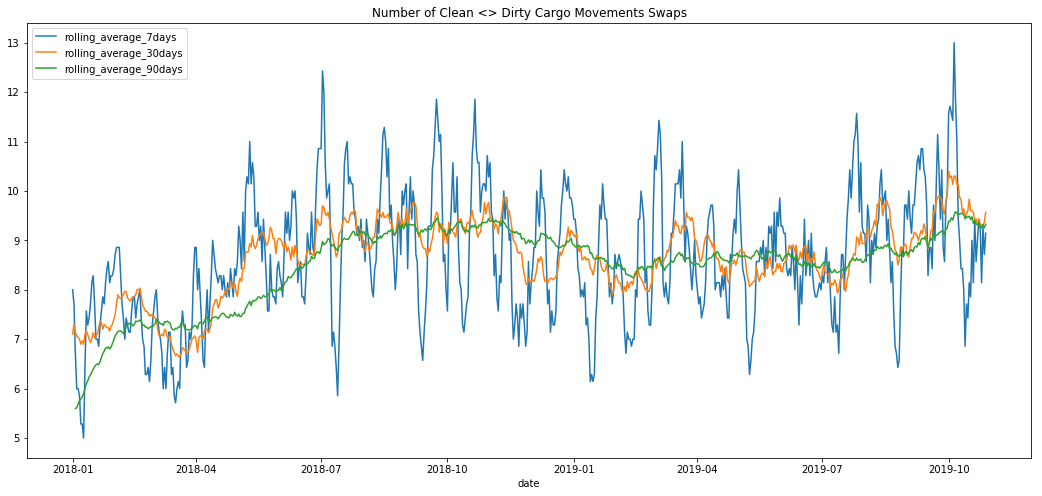

In [18]:
plot_with_rolling_averages(df=swaps_per_day,
                           plot_col='count',
                           min_date='2018-01-01',
                           title="Number of Clean <> Dirty Cargo Movements Swaps")

<a id='journey_times'></a>

## How has average journey time between US and Asia varied over the last year?

In [ ]:
us_to_asia = v.read_cargo_movements(origin_country='United States',
                                     destination_trading_region=['East Asia', 'Southeast Asia'])

average_journey_days = pd.DataFrame(us_to_asia.groupby('date')['duration_days'].mean())

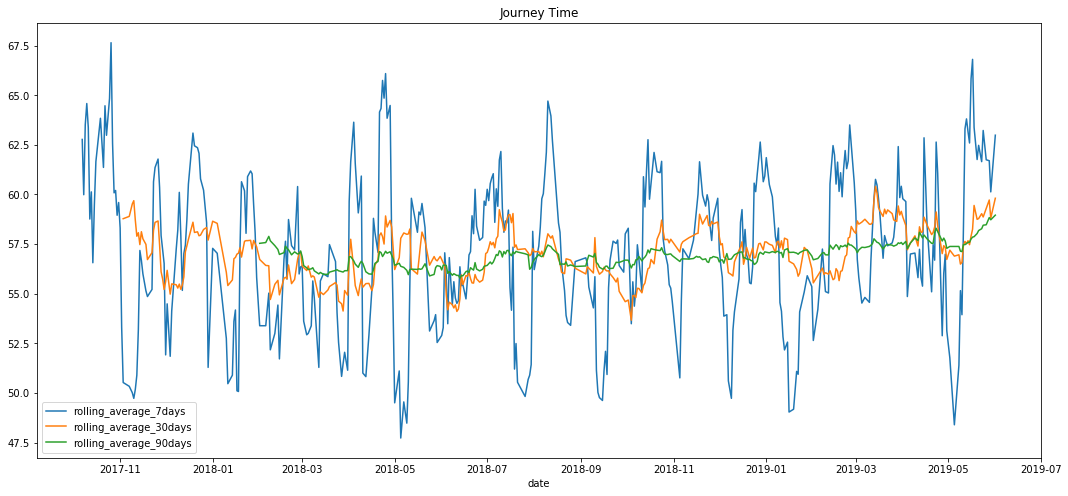

In [69]:
plot_with_rolling_averages(df=average_journey_days,
                           plot_col='duration_days',
                           max_date='2019-06-01',
                           title='Journey Time')

- (efford, reward) / 10
- (5, 2) Speed at which VLCC Ballast tankers are moving ASIA -> US GULF
- (2, 1) Speed of laden vessels from US to Asia
- (3, 2) US Crude exports VIA panama / VIA suez vs VIA cape
- (1, ?) No. of VLCCs loading form US gulf / US guls sts areas and heading to asia (by month)
- (3, ?) No. of tankrs visiting a shipyard (which shipyard) by month (could be fitting scrubbers, or maintenance)
- (7, ?) Average time spend in port for ballast tankers visiting US Gulf (how quickyl is logistical infrastructure improving, allowing for higher crude exports from US Gulf)
- (6, ?) Frequency of tankers changing clean -> dirty and dirty -> clean
- (5, ?) Net switch from Clean -> Dirty or Dirty -> Clean by vessel class
- (5, ?) No. of new tankers leaving shipyards per month, by vesselclass
- (10,?) Amount of times tanker has switched AIS off
- (8, ?) Vessel owner having many tankers moved out of or in to a region
- (8, ?) Vessel owner putting their tanker into shipyards (per month, per vessel owner), (so you know potentially who has put om the biggest orders for scrubbers) 